# Machine Learning Course Project
## Chantel A. Miller
### Predicting Mental Health Treatment Seekers from OSMI Mental Health in Tech Survey Respondents
https://www.kaggle.com/osmi/mental-health-in-tech-2016/data


**Description:** Through all of the contemporary dialogue on health care in the United States, mental health remains an interesting specter in our social consciousness. In the media, it is brought up infrequently, often an anecdotal, armchair diagnoses of victims or perpetrators of tragedies. In our social and private spaces, it is often underdiscussed and in extreme cases ignored or rejected entirely. These realizations prove especially consequential when coupled with the revelations by medical researchers and surveyors that mental health problems are far more prevalent in society than we might realize or even care to admit. In this project, we will apply machine learning techniques to mental health in tech survey data in an effort to predict individuals that will seek treatment for mental health issues and shed light on this important topic. 

In [244]:
# General
import pandas as pd
import numpy as np

# Plotting 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import pylab as plt 
%matplotlib inline
import seaborn as sns

# Model Fitting and Validation
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score, confusion_matrix, mean_squared_error, accuracy_score, classification_report 
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

# NLP
from wordcloud import WordCloud, STOPWORDS
import codecs
import base64
import imageio
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation

## Read in Data and Explore

In [245]:
df = pd.read_csv('osmi-survey14.csv')

In [246]:
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,8/27/2014 11:29,37,Female,United States,IL,NaN,No,Yes,Often,25-Jun,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,8/27/2014 11:29,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,8/27/2014 11:29,32,Male,Canada,NaN,NaN,No,No,Rarely,25-Jun,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,8/27/2014 11:29,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,8/27/2014 11:30,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


Initial review of dataframe indicates some cleanup will be necessary. Since this is survey data we want to look into each feature to see the variety of data reported.

- Gender: Inconsistent levels (males vs M) 
- NaN in many columns might cause errors depending on model selection
- Convert Yes/No binary features into dummies
- Convert Yes/No/maybe features into dummies
- work_interfere, leave: Reclassify ordinal data using dummies

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
Timestamp                    1259 non-null object
Age                          1259 non-null int64
Gender                       1259 non-null object
Country                      1259 non-null object
state                        744 non-null object
self_employed                1241 non-null object
family_history               1259 non-null object
treatment                    1259 non-null object
work_interfere               995 non-null object
no_employees                 1259 non-null object
remote_work                  1259 non-null object
tech_company                 1259 non-null object
benefits                     1259 non-null object
care_options                 1259 non-null object
wellness_program             1259 non-null object
seek_help                    1259 non-null object
anonymity                    1259 non-null object
leave                        1259 non-null obj

Let's look at the unique levels in each column to see what needs reclassification or standardizing.

In [248]:
df['Gender'].unique()

array(['Female', 'M', 'Male', 'male', 'female', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they',
       'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'All', 'Enby',
       'fluid', 'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous',
       'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)',
       'queer', 'Female (cis)', 'Mail', 'cis male', 'A little about you',
       'Malr', 'p', 'femail', 'Cis Man',
       'ostensibly male, unsure what that really means'], dtype=object)

This will be interesting...

In [249]:
unique_levels = {}
for i in list(df):
    if i not in ['Timestamp', 'comments']:
        unique_levels[i] = df[i].unique()

In [250]:
unique_levels

{'Age': array([         37,          44,          32,          31,          33,
                 35,          39,          42,          23,          29,
                 36,          27,          46,          41,          34,
                 30,          40,          38,          50,          24,
                 18,          28,          26,          22,          19,
                 25,          45,          21,         -29,          43,
                 56,          60,          54,         329,          55,
        99999999999,          48,          20,          57,          58,
                 47,          62,          51,          65,          49,
              -1726,           5,          53,          61,           8,
                 11,          -1,          72], dtype=int64),
 'Country': array(['United States', 'Canada', 'United Kingdom', 'Bulgaria', 'France',
        'Portugal', 'Netherlands', 'Switzerland', 'Poland', 'Australia',
        'Germany', 'Russia', 'Mexico', 'Br

Unique values per feature do not look as bad as initially thought. 

- *Age* has some unexpected values, negatives, very large, very small given this is a workforce survey. 
- *Gender* has typogrpahic errors and a wide variety of responses but can be simplified using logical groupings: Male, Female, Non-Binary. Grouping everything not male/female into non-binary likely has drawbacks both socially and statistically. The incidence of these values is low in this dataset however and rather than have many small class sizes, aggregating helps us retain this information where there are relationships between datapoints.
- *No_employees* looks to have suffered from a reformatting issue. 5-Jan is likely 1-5, 25-Jun is likely 6-25

### Age

For the Ages that look unusual, what does the rest of the data look like? 

In [251]:
df.loc[df['Age'].isin([99999999999, -29, -1726, 5, 8, 11, -1, 329])]

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
143,8/27/2014 12:39,-29,Male,United States,MN,No,No,No,NaN,More than 1000,...,Don't know,No,No,Some of them,Yes,No,No,Don't know,No,NaN
364,8/27/2014 15:05,329,Male,United States,OH,No,No,Yes,Often,25-Jun,...,Don't know,Maybe,No,Some of them,No,No,No,No,No,NaN
390,8/27/2014 15:24,99999999999,All,Zimbabwe,NaN,Yes,Yes,Yes,Often,5-Jan,...,Very difficult,Yes,Yes,No,No,Yes,No,No,Yes,NaN
715,8/28/2014 10:07,-1726,male,United Kingdom,NaN,No,No,Yes,Sometimes,26-100,...,Somewhat difficult,Yes,No,No,No,No,Maybe,Don't know,No,NaN
734,8/28/2014 10:35,5,Male,United States,OH,No,No,No,NaN,100-500,...,Somewhat easy,No,No,Yes,Yes,No,No,Yes,No,We had a developer suffer from depression and ...
989,8/29/2014 09:10,8,A little about you,"Bahamas, The",IL,Yes,Yes,Yes,Often,5-Jan,...,Very easy,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,
1090,8/29/2014 17:26,11,male,United States,OH,Yes,No,No,Never,5-Jan,...,Very easy,No,No,Some of them,Some of them,No,Maybe,Yes,No,NaN
1127,8/30/2014 20:55,-1,p,United States,AL,Yes,Yes,Yes,Often,5-Jan,...,Very easy,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,password: testered


Row 989 and 1127 will just be dropped based on likely erroneous data in multiple columns (age, gender, country/state, and yes's across the board).

Row 143 Age of -29 could reasonably be a typo for 29. 

In [252]:
df = df.loc[~df['Age'].isin([8, -1])]
df['Age'].loc[df['Age'] == -29] = 29

In [253]:
df.loc[df['Age'].isin([99999999999, -29, -1726, 5, 8, 11, -1, 329])]

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
364,8/27/2014 15:05,329,Male,United States,OH,No,No,Yes,Often,25-Jun,...,Don't know,Maybe,No,Some of them,No,No,No,No,No,NaN
390,8/27/2014 15:24,99999999999,All,Zimbabwe,NaN,Yes,Yes,Yes,Often,5-Jan,...,Very difficult,Yes,Yes,No,No,Yes,No,No,Yes,NaN
715,8/28/2014 10:07,-1726,male,United Kingdom,NaN,No,No,Yes,Sometimes,26-100,...,Somewhat difficult,Yes,No,No,No,No,Maybe,Don't know,No,NaN
734,8/28/2014 10:35,5,Male,United States,OH,No,No,No,NaN,100-500,...,Somewhat easy,No,No,Yes,Yes,No,No,Yes,No,We had a developer suffer from depression and ...
1090,8/29/2014 17:26,11,male,United States,OH,Yes,No,No,Never,5-Jan,...,Very easy,No,No,Some of them,Some of them,No,Maybe,Yes,No,NaN


For the remaining data points we simply remove them. 

Originally hoped to use np's missing values for age since there is valuable data in the other columns, however the missing values caused problems in model fitting. Could impute values instead of dropping these rows.

In [254]:
#df['Age'].loc[df['Age'].isin([99999999999, -29, -1726, 5, 8, 11, -1, 329])] = np.nan 
df = df[~df['Age'].isin([99999999999, -29, -1726, 5, 8, 11, -1, 329])]

In [255]:
df['Age'].unique()

array([37, 44, 32, 31, 33, 35, 39, 42, 23, 29, 36, 27, 46, 41, 34, 30, 40,
       38, 50, 24, 18, 28, 26, 22, 19, 25, 45, 21, 43, 56, 60, 54, 55, 48,
       20, 57, 58, 47, 62, 51, 65, 49, 53, 61, 72], dtype=int64)

### Gender

Standardize male and female gender.

In [256]:
unique_levels['Gender']

array(['Female', 'M', 'Male', 'male', 'female', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they',
       'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'All', 'Enby',
       'fluid', 'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous',
       'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)',
       'queer', 'Female (cis)', 'Mail', 'cis male', 'A little about you',
       'Malr', 'p', 'femail', 'Cis Man',
       'ostensibly male, unsure what that really means'], dtype=object)

In [257]:
df['Gender'].loc[df['Gender'].isin(['female', 'Cis Female', 'Woman', 'F', 'f', 'Femake', 'woman', 'Female ', 'cis-female/femme', 'Female (cis)', 'femail'])] = 'Female'

In [258]:
df['Gender'].loc[df['Gender'].isin(['M', 'male', 'm', 'maile', 'Cis Male', 'Mal', 'Male (CIS)', 'Make', 'Male ', 'Man', 'msle', 'Mail', 'cis male', 'Malr', 'Cis Man'])] = 'Male'

C:\Users\cmill\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [259]:
df['Gender'].loc[df['Gender'].isin([ 'Trans-female', 'Male-ish',
       'something kinda male?', 'queer/she/they', 'non-binary', 'Nah',
       'All', 'Enby', 'fluid', 'Genderqueer', 'Androgyne', 'Agender',
       'Guy (-ish) ^_^', 'male leaning androgynous', 'Trans woman',
       'Neuter', 'Female (trans)', 'queer',
       'ostensibly male, unsure what that really means'])] = 'Non-Binary'

C:\Users\cmill\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [260]:
df['Gender'].unique()

array(['Female', 'Male', 'Non-Binary'], dtype=object)

### No_Employees

In [261]:
unique_levels['no_employees']

array(['25-Jun', 'More than 1000', '26-100', '100-500', '5-Jan', '500-1000'], dtype=object)

In [262]:
df['no_employees'].loc[df['no_employees'] == '25-Jun'] = '6-25'
df['no_employees'].loc[df['no_employees'] == '5-Jan'] = '1-5'

C:\Users\cmill\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [263]:
df['no_employees'].unique()

array(['6-25', 'More than 1000', '26-100', '100-500', '1-5', '500-1000'], dtype=object)

### Missing Values

In [264]:
df_nan_cols = df.drop(['state', 'comments'], axis=1)
df_nan_cols[df_nan_cols.isnull().any(axis=1)]

,Timestamp,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,8/27/2014 11:29,37,Female,United States,NaN,No,Yes,Often,6-25,No,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,8/27/2014 11:29,44,Male,United States,NaN,No,No,Rarely,More than 1000,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,8/27/2014 11:29,32,Male,Canada,NaN,No,No,Rarely,6-25,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,8/27/2014 11:29,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,8/27/2014 11:30,31,Male,United States,NaN,No,No,Never,100-500,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No
5,8/27/2014 11:31,33,Male,United States,NaN,Yes,No,Sometimes,6-25,No,...,Don't know,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No
6,8/27/2014 11:31,35,Female,United States,NaN,Yes,Yes,Sometimes,1-5,Yes,...,No,Somewhat difficult,Maybe,Maybe,Some of them,No,No,No,Don't know,No
7,8/27/2014 11:32,39,Male,Canada,NaN,No,No,Never,1-5,Yes,...,Yes,Don't know,No,No,No,No,No,No,No,No
8,8/27/2014 11:32,42,Female,United States,NaN,Yes,Yes,Sometimes,100-500,No,...,No,Very difficult,Maybe,No,Yes,Yes,No,Maybe,No,No
9,8/27/2014 11:32,23,Male,Canada,NaN,No,No,Never,26-100,No,...,Don't know,Don't know,No,No,Yes,Yes,Maybe,Maybe,Yes,No


281 rows seems like a lot. How many in each column?

In [265]:
df_nan_cols.isnull().sum()

Timestamp                      0
Age                            0
Gender                         0
Country                        0
self_employed                 18
family_history                 0
treatment                      0
work_interfere               263
no_employees                   0
remote_work                    0
tech_company                   0
benefits                       0
care_options                   0
wellness_program               0
seek_help                      0
anonymity                      0
leave                          0
mental_health_consequence      0
phys_health_consequence        0
coworkers                      0
supervisor                     0
mental_health_interview        0
phys_health_interview          0
mental_vs_physical             0
obs_consequence                0
dtype: int64

263 are in work_interfere, let's just drop that one.

In [266]:
df = df.drop('work_interfere', axis = 1)
len(df)

1252

What do the 18 NA self_employed respondents look like? 

In [267]:
df[df['self_employed'].isnull()]

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,no_employees,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,8/27/2014 11:29,37,Female,United States,IL,NaN,No,Yes,6-25,No,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,8/27/2014 11:29,44,Male,United States,IN,NaN,No,No,More than 1000,No,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,8/27/2014 11:29,32,Male,Canada,NaN,NaN,No,No,6-25,No,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,8/27/2014 11:29,31,Male,United Kingdom,NaN,NaN,Yes,Yes,26-100,No,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,8/27/2014 11:30,31,Male,United States,TX,NaN,No,No,100-500,Yes,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
5,8/27/2014 11:31,33,Male,United States,TN,NaN,Yes,No,6-25,No,...,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No,NaN
6,8/27/2014 11:31,35,Female,United States,MI,NaN,Yes,Yes,1-5,Yes,...,Somewhat difficult,Maybe,Maybe,Some of them,No,No,No,Don't know,No,NaN
7,8/27/2014 11:32,39,Male,Canada,NaN,NaN,No,No,1-5,Yes,...,Don't know,No,No,No,No,No,No,No,No,NaN
8,8/27/2014 11:32,42,Female,United States,IL,NaN,Yes,Yes,100-500,No,...,Very difficult,Maybe,No,Yes,Yes,No,Maybe,No,No,NaN
9,8/27/2014 11:32,23,Male,Canada,NaN,NaN,No,No,26-100,No,...,Don't know,No,No,Yes,Yes,Maybe,Maybe,Yes,No,NaN


Looks like valid data for the rest of the fields. *sigh* Let's drop them for now for convenience but these may be good candidates for data imputation also.

Interesting that these seem to be the first 18 records of the data...perhaps there was a collection issue or self employed was introduced as a field after the survey began. 

In [268]:
df = df[~df['self_employed'].isnull()]

In [269]:
len(df)

1234

## Graphical EDA

Let's look at some of our demographic data to learn more about the distributions in our respondents.

In [270]:
plot_data = {}

for feature in list(df):
    if feature not in ['Timestamp', 'comments']:
        #plot_details = []
        plot_data[feature] = [[go.Bar(
            x=df.groupby(feature).size().index,
            y=df.groupby(feature).size()
    )], go.Layout(title="%s Distribution" % feature, xaxis={'title': feature}, yaxis={'title':'frequency'})]
        plot_data[feature].append(go.Figure(data=plot_data[feature][0], layout = plot_data[feature][1]))
            


In [271]:
iplot(plot_data['treatment'][2])

Data for our dependent variable, whether individuals sought treatment is balanced. 

In [272]:
iplot(plot_data['Age'][2])

Age distribution of respondents is centered around 30, starting at 18 with a long tail out to 72. This is consistent with expectations from the technology industry.

In [273]:
iplot(plot_data['Gender'][2])

Responders are mostly male, unsurprising given the survey is of employees in technology.

In [274]:
iplot(plot_data['family_history'][2])

60% of the respondents have a family history of mental health problems which we anticipate to be a strong predictor of seeking mental health treatment.

In [275]:
iplot(plot_data['self_employed'][2])

Most respondents are not self employed.

In [276]:
iplot(plot_data['no_employees'][2])

We see a reasonable distribution of company sizes. Interestingly there are not a lot of midsized companies. 

In [277]:
state_count = pd.DataFrame({'State': df.groupby(['state']).size().index,
                            'Count': df.groupby(['state']).size()})
test = [ dict(
            type = 'choropleth',
            locations = state_count['State'],
            z = state_count['Count'],
            locationmode = 'USA-states',
            reversescale = False,
            colorbar = dict(title = 'Count of Responders')
)]

layout = dict(
            title='Respondent Density by State',
            geo = dict(
                scope='usa',
                showframe=False,
                projection={'type':'Mercator'}
))

choromap = go.Figure(data = test,layout = layout)
iplot(choromap,validate=False)

In the United States, most of our responders are in California (137), Washington (70), New York (54), and Texas and Tennessee (43). Tennessee was a little surprising but apparently they have a flourishing tech scene particularly in health and digital entertainment. The more you know.

## Prepare data for analysis

Create dummies for categorical dependent variables.

In [278]:
df.groupby(['Country']).size()

Country
Australia                  21
Austria                     3
Belgium                     6
Bosnia and Herzegovina      1
Brazil                      6
Bulgaria                    3
Canada                     68
China                       1
Colombia                    2
Costa Rica                  1
Croatia                     2
Czech Republic              1
Denmark                     2
Finland                     3
France                     13
Georgia                     1
Germany                    45
Greece                      2
Hungary                     1
India                      10
Ireland                    27
Israel                      5
Italy                       7
Japan                       1
Latvia                      1
Mexico                      3
Moldova                     1
Netherlands                27
New Zealand                 8
Nigeria                     1
Norway                      1
Philippines                 1
Poland                      7
Po

Most of the respondents are in the US so let's bucket country into US and outside it.

In [279]:
df['USA'] = df['Country'].apply(lambda x: 1 if x == 'United States' else 0)

Let's create a variable for if people comment to see if whether or not someone decides to leave survey comments has any predictive power.

In [280]:
df['commenter'] = df['comments'].apply(lambda x: 1 if x == np.nan else 0)

In [281]:
# below causes memory issues...
# for col in list(df):
#     if col not in ['Timestamp', 'Age', 'Country', 'state', 'treatment', 'comments']:
#         df = df.append(pd.get_dummies(df[[col]], drop_first=True))

dummy_cols = [col for col in list(df) if col not in ['Timestamp', 'Age', 'Country', 'state', 'comments', 'USA']]

df_dummies = pd.get_dummies(df[dummy_cols], drop_first=True)

#df_dummies = df_dummies.append(df[['Age', 'treatment', 'USA']]) # appending as NaN - why? 

model_df = pd.concat([df_dummies, df[['Age', 'USA']]], axis = 1)

In [282]:
model_df.head() 

,commenter,Gender_Male,Gender_Non-Binary,self_employed_Yes,family_history_Yes,treatment_Yes,no_employees_100-500,no_employees_26-100,no_employees_500-1000,no_employees_6-25,...,supervisor_Yes,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_Yes,Age,USA
18,0,1,0,1,1,0,0,0,0,0,...,1,1,0,0,1,0,1,1,46,1
19,0,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,36,0
20,0,1,0,0,1,1,1,0,0,0,...,0,1,0,1,0,1,0,0,29,1
21,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,31,1
22,0,1,0,0,0,1,0,1,0,0,...,1,1,0,0,0,1,0,0,46,1


In [283]:
df_x = model_df.drop(['treatment_Yes'], axis = 1)
df_y = model_df['treatment_Yes']

Check for strong collinearity between our variables.

In [284]:
df_x_corr = df_x.corr()

(((df_x_corr > 0.75) & (df_x_corr < 1)).any() | (df_x_corr < -0.75).any())

commenter                        False
Gender_Male                      False
Gender_Non-Binary                False
self_employed_Yes                False
family_history_Yes               False
no_employees_100-500             False
no_employees_26-100              False
no_employees_500-1000            False
no_employees_6-25                False
no_employees_More than 1000      False
remote_work_Yes                  False
tech_company_Yes                 False
benefits_No                      False
benefits_Yes                     False
care_options_Not sure            False
care_options_Yes                 False
wellness_program_No              False
wellness_program_Yes             False
seek_help_No                     False
seek_help_Yes                    False
anonymity_No                     False
anonymity_Yes                    False
leave_Somewhat difficult         False
leave_Somewhat easy              False
leave_Very difficult             False
leave_Very easy          

Create training and test data sets. 

In [285]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, train_size = 0.7, random_state = 2)

### Construct Classifers

All of the models selected are well suited for classification problems. We will run simple classifiers as well as some classifiers with tuned parameters to see which best handle our data.

In [286]:
classifier_names = ['Logit', 'DecisionTree', 'GradientBoosting', 'RandomForest', 'MLP', 'LogitRegularized', 'DecisionTreePruned']

# Simple Classifiers
logit = LogisticRegression(C=1e5)
dt = tree.DecisionTreeClassifier(criterion="gini", min_samples_split=10)
gbt = GradientBoostingClassifier(learning_rate=0.2, n_estimators=1000, max_depth=3)
rf = RandomForestClassifier(max_depth = 3, random_state = 0)
mlp = MLPClassifier(solver='lbfgs', alpha = 1e-5, hidden_layer_sizes=(42,42,42), random_state = 1)

# Regularized Classifiers
tuned_parameters = {'C': list(np.power(10.0, np.arange(-10, 10)))}
parameters = {'max_depth':list(range(3,20))}

logit_reg = GridSearchCV(LogisticRegression(), tuned_parameters, cv=3, scoring="roc_auc")
dt_pruned = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4) 

classifier_obj = [logit, dt, gbt, rf, mlp, logit_reg, dt_pruned]

models_dict = dict(zip(classifier_names, classifier_obj))

### Let's create functions to store evaluation metrics.

In [287]:
def add_results(results, clf, classifier_name):
    results[classifier_name] = {'Accuracy': accuracy_score(df_test_y, clf.predict(df_test_x)),
                        'Test Error Rate': np.mean(clf.predict(df_test_x) != df_test_y),
                        'Training Error Rate': np.mean(clf.predict(df_train_x) != df_train_y),
                        'ConfMat': pd.crosstab(index=df_test_y, columns=clf.predict(df_test_x), rownames=['True'], colnames=['Predicted'])
                        }
    return results


def plot_roc_curve(clf, classifier_name):
    fpr, tpr, threshoolds = roc_curve(df_test_y, clf.predict(df_test_x))

    fpr_rand = tpr_rand = np.linspace(0, 1, 10)
    plt.plot(fpr, tpr) 
    plt.plot(fpr_rand, tpr_rand, linestyle='--') 
    plt.title('ROC Curve for %s' % classifier_name)
    plt.show()
    

Let's calculate our evaluation metrics for the classifiers we defined

In [288]:
model_results = {}

for k, v in models_dict.items():
    v.fit(df_train_x, df_train_y)
    add_results(model_results, v, k)
    

### Model evaluation

In [289]:
model_accuracies = {x:model_results[x]['Accuracy'] for x in [k for k,v in model_results.items()]}
sorted(model_accuracies.items(), key = lambda x:x[1])[::-1]

[('LogitRegularized', 0.71967654986522911),
 ('DecisionTreePruned', 0.71159029649595684),
 ('MLP', 0.70350404312668469),
 ('Logit', 0.70350404312668469),
 ('RandomForest', 0.6846361185983828),
 ('GradientBoosting', 0.68194070080862534),
 ('DecisionTree', 0.60646900269541781)]

Disappointingly, none of our model accuracies are especially strong. We definitely see some improvement over random guessing which could be used to build stronger models in the future. The best based on holdout accuracy is the regularized logit, folowed by the pruned decision tree and multi-layer perceptron.

Let's look into the models that did best.

In [290]:
def describe_results(classifier_name, classifier_metric):
    print("%s %s is:" % (classifier_name, classifier_metric), model_results[classifier_name][classifier_metric])

## Regularized Logit

_Accuracy_

In [291]:
describe_results('LogitRegularized', 'Accuracy')

LogitRegularized Accuracy is: 0.719676549865


Our regularized logistic regression with tuned cost parameters had the highest accuracy of classifying survey respondents most likely to seek treatment at approximately 72%. While this is not a strong accuracy, it could be used as a baseline for future interventions or follow ups since it is much better than random guessing. Additionally, it could be the starting point of a stronger model through ensembling or additional data. Regularizing the logistic regression also had a positive impact on predictive power as it improved on the accuracy of the simple logistic regression by about 2 percentage points.

_Confusion Matrix_

In [292]:
describe_results('LogitRegularized', 'ConfMat')

LogitRegularized ConfMat is: Predicted    0    1
True               
0          135   55
1           49  132


The confusion matrix shows that both the classification and misclassification rates were about the same, we correctly classified true positives at the same rate that we correctly classified true negatives. This is also true for our misclassification rate. Though our overall model accuracy isn't as high as we would like, this does indicate some model stability as we don't appear to be biased towards a particular class.

_Training and Test Error Rates_

In [293]:
describe_results('LogitRegularized', 'Training Error Rate')

LogitRegularized Training Error Rate is: 0.264194669757


In [294]:
describe_results('LogitRegularized', 'Test Error Rate')

LogitRegularized Test Error Rate is: 0.280323450135


Training and test error rates are consistent with what we see for overall accuracy. There is some degradation between training and test but not so much that we should be overly concerned about our model being overfit on training data.

_ROC Curve_

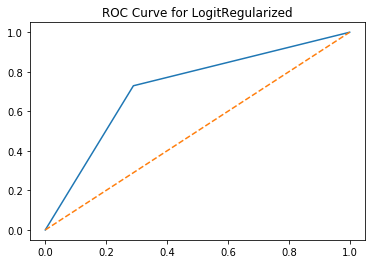

In [295]:
plot_roc_curve(logit_reg, 'LogitRegularized')

As we can see from the ROC curve, the regularized logit (blue) does much better on ROC than random (orange line). 

_Feature Importance_

In [296]:
logit_reg_importance = dict(zip(list(df_x), logit_reg.best_estimator_.coef_.reshape(43)))

In [297]:
logit_reg_imp_sort = sorted(logit_reg_importance.items(), key=lambda x: abs(x[1]))[::-1][:10]

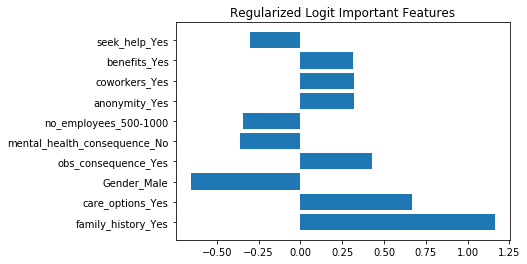

In [298]:
logit_reg_top_feats = list(zip(*logit_reg_imp_sort))[0]
logit_reg_top_vals = list(zip(*logit_reg_imp_sort))[1]

y_pos = range(10)
plt.barh(y_pos, logit_reg_top_vals, align='center') 
plt.yticks(y_pos, logit_reg_top_feats) 
plt.title('Regularized Logit Important Features')
plt.show()

Our most important features determined by logistic regression include a family history of mental health, the availability of care options and being male had a negative impact. 

## Pruned Decision Tree

_Accuracy_

In [299]:
describe_results('DecisionTreePruned', 'Accuracy')

DecisionTreePruned Accuracy is: 0.711590296496


The pruned decision tree performed competitively with the regularized logistic regression at 71% accuracy. Again, not spectacular results but more effective than random guessing.

_Confusion Matrix_

In [300]:
describe_results('DecisionTreePruned', 'ConfMat')

DecisionTreePruned ConfMat is: Predicted    0    1
True               
0          120   70
1           37  144


Interestingly with the pruned decision tree, there appears to be an imbalance in our classification rate. As indicated by the higher number of true positive and lower number of false positive, this model appeared stronger at predicting positives accurately relative to predicting negatives. We may be able to tweak this model to account for that, penalizing false negatives more severely. Given this factor though it is another reason to defer to the regularized logit results. 

_Training and Test Error Rates_

In [301]:
describe_results('DecisionTreePruned', 'Training Error Rate')

DecisionTreePruned Training Error Rate is: 0.298957126304


In [302]:
describe_results('DecisionTreePruned', 'Test Error Rate')

DecisionTreePruned Test Error Rate is: 0.288409703504


Our test error rate, while similar to training is actually a little better. This is an unusual result but given how close they are it is not a huge concern.

_ROC Curve_

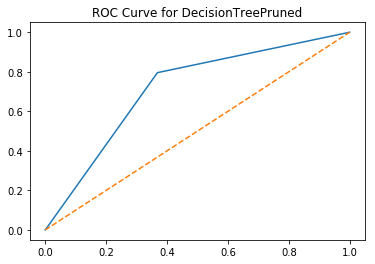

In [303]:
plot_roc_curve(dt_pruned, 'DecisionTreePruned')

The ROC curve also looks good and clearly indicates a better performance than random guessing.

_Feature Importances_

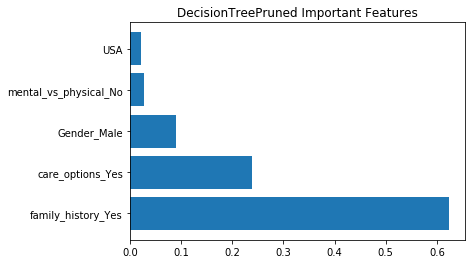

In [304]:
dt_imp_features = dt_pruned.best_estimator_.feature_importances_
sorted_indices = np.argsort(dt_imp_features)[::-1]

y_pos = range(5)
plt.barh(y_pos, dt_imp_features[sorted_indices][:5], align='center') 
plt.yticks(y_pos, df_train_x.columns[sorted_indices][:5]) 
plt.title('DecisionTreePruned Important Features')
plt.show()

Like the regularized logit, family history of mental illness and availability of care options, and gender_male were the top three features. This gives us a bit more confidence in the relevance of these features.

## Multi-layer Perceptron

_Accuracy_

In [305]:
describe_results('MLP', 'Accuracy')

MLP Accuracy is: 0.703504043127


Slightly lower accuracy than our previous two models. Given the difficulty in interpreting neural networks, since this model does not perform significantly better than any of the others we would prefer to use one of the others for additional analysis.

_Confusion Matrix_

In [306]:
describe_results('MLP', 'ConfMat')

MLP ConfMat is: Predicted    0    1
True               
0          129   61
1           49  132


The confusin matrix for our neural network seems fairly balanced.

_Training and Test Error Rates_

In [307]:
describe_results('MLP', 'Training Error Rate')

MLP Training Error Rate is: 0.257242178447


In [308]:
describe_results('MLP', 'Test Error Rate')

MLP Test Error Rate is: 0.296495956873


Of our top models, the training error rate is actually best on the neural network but it is noticeably weaker when predicting the test data, particularly compared to the other models. This is an indicator that our neural network might be a bit overfit.

_ROC Curve_

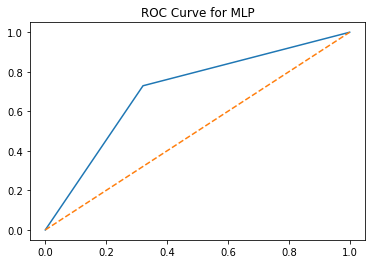

In [309]:
plot_roc_curve(mlp, 'MLP')

We can see the ROC curve is a little worse than our previous two as well. 

_Feature Importances_ 

One of the weakness of neural networks is the lack of interpretability so it is difficult to say which are strong contributors to our classifier.

## Model Conclusions

At 71.9% accuracy on holdout data, the regularized logit performs best with the added advantage of being a simpler model to explain and interpret. The only model that truly did poorly was the decision tree at 58% accuracy, but we were able to see considerable improvement on that by pruning the tree using crossvalidation to find the optimal length. While the 71.9% accuracy of our best model isn't an incredible result, it gives us a foundation on which to build and improve, potentially leveraging data from a more recent version of the survey - https://www.kaggle.com/osmi/mental-health-in-tech-2016


## What about the comments? Can we learn anything from those? 

In [310]:
comments = list(df['comments'][~df['comments'].isnull()])

In [311]:
with open("brain.png", "rb") as imagefile:
    image_data = imagefile.read()
    eap_64 = base64.b64encode(image_data)

img_file = open("brain.png", "wb")
img_file.write(codecs.decode(eap_64, 'base64'))
img_file.close()

img = imageio.imread("brain.png")
hcmask = img

C:\Users\cmill\Anaconda3\lib\site-packages\PIL\Image.py:888: UserWarning:

Palette images with Transparency   expressed in bytes should be converted to RGBA images



(-0.5, 511.5, 511.5, -0.5)

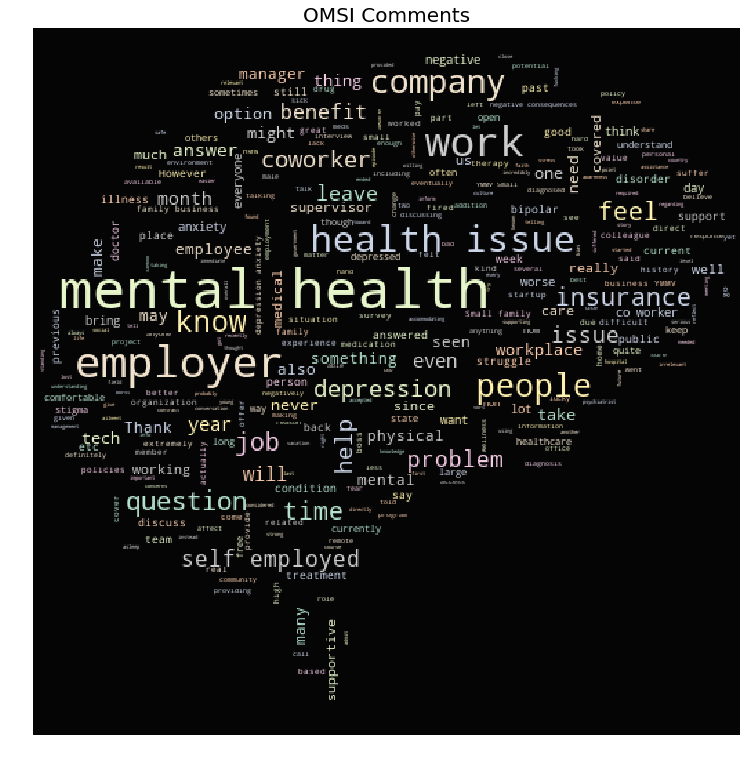

In [312]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               mask=hcmask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(comments))
plt.title("OMSI Comments", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

Some obvious terms jump out from our (brain shaped) word cloud excluding stop words. 'Mental health', 'health', 'issue', 'employer', 'insurance', 'depression'. Let's see what we can determine after cleaning the comments and reviewing them quantitatively. 

## Natural Language Processing

### Tokenize each comment.

In [313]:
list_comments = []
for comment in comments: 
    list_comments.append(nltk.word_tokenize(comment))

In [314]:
list_comments[0]

['Relatively', 'new', 'job', '.', 'Ask', 'again', 'later']

### Remove stop words

In [315]:
stopwords = nltk.corpus.stopwords.words('english')

In [316]:
list_comments_cleaned = []

for comment in list_comments:
    list_comments_cleaned.append([word for word in comment if word.lower() not in stopwords])

In [317]:
list_comments_cleaned[0]

['Relatively', 'new', 'job', '.', 'Ask', 'later']

See that the stop word 'again' was removed from the first record.

### Stemming & Lemmatization

Simplify words to their roots 

In [318]:
lemm = nltk.stem.WordNetLemmatizer()

#lemm.lemmatize(first_text_list_cleaned[0])

comments_lemm = []

for comment in list_comments_cleaned:
    comments_lemm.append([lemm.lemmatize(word) for word in comment])

In [319]:
list_comments_cleaned == comments_lemm

False

Our lemmatized array is different from the non lemmatized one, lets find an example of what changed.

In [320]:
len([x for x in comments_lemm if x not in list_comments_cleaned])

111

111 of our 158 comments were changed by the lemmatizer.

In [321]:
list_comments_cleaned[1]

['Sometimes',
 'think',
 'using',
 'drugs',
 'mental',
 'health',
 'issues',
 '.',
 'use',
 'drugs',
 'feel',
 'better']

In [322]:
comments_lemm[1]

['Sometimes',
 'think',
 'using',
 'drug',
 'mental',
 'health',
 'issue',
 '.',
 'use',
 'drug',
 'feel',
 'better']

In the above example, plural words like 'drugs' and 'issues' were converted to their singular form. This will allow us to treat words with similar roots the same in our analysis.

Now that we have our words simplified, what words are most comment in our data set? We explored this qualitatively before preprocessing with the word cloud, now let's explore quantitatively.

In [323]:
vectorizer = CountVectorizer(min_df=0)

In [324]:
flat_list = [item for sublist in comments_lemm for item in sublist]

In [325]:
comments_transform = vectorizer.fit_transform(flat_list)

In [326]:
vocab = vectorizer.get_feature_names()
comment_word_counts = comments_transform.sum(axis=0).A1
freq_distr = Counter(dict(zip(vocab, comment_word_counts)))
freq_distr_sorted = dict(sorted(freq_distr.items(), key=lambda x: x[1])[::-1][:50])

freq_distr_sorted_inv = dict(sorted(freq_distr.items(), key=lambda x: x[1])[:50])

In [327]:
count_plot = [go.Bar(
                x=list(freq_distr_sorted.keys()),
                y=list(freq_distr_sorted.values()))]

count_layout = go.Layout(title="Comment Word Frequency Top Words", xaxis={'title': 'words'}, yaxis={'title':'frequency'})
      #  plot_data[feature].append(go.Figure(data=plot_data[feature][0], layout = plot_data[feature][1]))

    
    
iplot(go.Figure(data=count_plot, layout = count_layout))

Reaffirming what we saw visually. Top words: mental, health, employer, issue, work. 

In [328]:
count_plot = [go.Bar(
                x=list(freq_distr_sorted_inv.keys()),
                y=list(freq_distr_sorted_inv.values()))]

count_layout = go.Layout(title="Comment Word Frequency Bottom Words", xaxis={'title': 'words'}, yaxis={'title':'frequency'})
      
iplot(go.Figure(data=count_plot, layout = count_layout))

The bottom words can be helpful to visualize as some might convey significant meaning for our analysis. These might be 'abuse', 'accomdation', 'antidepressant' etc

## Topic Modelling

Looking for patterns in comments based on word similarities. 

In [329]:
lda = LatentDirichletAllocation(n_components=5, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [330]:
lda.fit(comments_transform)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=5, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [331]:
for i in lda.components_:
    print('Size of topic: ', len(i))
    

Size of topic:  1283
Size of topic:  1283
Size of topic:  1283
Size of topic:  1283
Size of topic:  1283


In [332]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [333]:
print_top_words(lda, vocab, 30)


Topic #0:mental job feel coworkers could workplace covered day worse policy bipolar think person bring others condition open pay still comfortable free survey told worked role med lucky woman given male

Topic #1:employer issue company know ve help family month never benefit might one physical something co worker supervisor treatment disorder large place current related say currently long direct program though suffer

Topic #2:work get insurance even manager thing take employee working well understand doctor team like however illness community go quite experience thanks ymmv therapy bos medication cover part took bad better

Topic #3:depression question time leave small anxiety negative seen tech also really since care may want medical answered good public business keep often sometimes non previous offer said stigma fired office

Topic #4:health would people employed self problem year option answer make need much many discus supportive support lot struggle etc back week everyone past 

There appears to be a lot of overlap in our topics so we may need to tune the LDA to get more distinct groupings. Given that the nature of the survey, it isn't surprising that they should all reference mental health in the workplace. All topics reference specific conditions (bipolar, disorder, anxiety, depression, depressed). Topics 1 and 2 indicate treatment options (treatment, insurance/doctor/medication. Topic 0 seems to refer a lot to other people (coworkers, person, others, woman, male). Topic 1 seems to be the only topic that references family. 

## Next Steps

- Feature selection to improve model performance
- Consider other eval metrics
- Are there any NLP packages that are specific for medical or mental health terminology? 
    - Can we focus in on extracting words related specifically to mental health like medication or conditions? 
- Feed NLP analysis of comments into a classifier
    - We did not find that commenting alone was a significant predictor in any of our models but perhaps the content of the comment can be used to improve classification. After tuning the number of topics, we could use membership in one of these topics as an independent variable and see if that improves accuracy.
    - So far, analysis has only considered individual words. What if we looked at a comment as a whole and the words associated with it and not just all of the words in our comments together. A neural net might be helpful here in remembering the last word that was stated. Is there any way to devise a sentiment score for each comment related to what we are trying to classify?